---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Chialing Sung
number-sections: true
date: "2025-04-10"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [27]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("lightcast_job_postings.csv") 

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

#df.printSchema() 
#df.show(5)

---This is Diagnostic check, No need to print it in the final doc---


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [28]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col

# Step 1: Drop rows with nulls in selected columns
selected_columns = ["SALARY", "MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "REMOTE_TYPE_NAME"]
df_clean = df.dropna(subset=selected_columns)

from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 2: Encode the categorical variable
indexer = StringIndexer(inputCol="REMOTE_TYPE_NAME", outputCol="REMOTE_TYPE_INDEX")
encoder = OneHotEncoder(inputCol="REMOTE_TYPE_INDEX", outputCol="REMOTE_TYPE_VEC")

from pyspark.ml.feature import VectorAssembler

# Step 3: Assemble features
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "REMOTE_TYPE_VEC"],
    outputCol="features"
)

from pyspark.ml import Pipeline

# Create pipeline for transformation
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Apply pipeline
df_transformed = pipeline.fit(df_clean).transform(df_clean)

# Show example
df_transformed.select("SALARY", "features").show(5, truncate=False)

# Step 5: Split the data
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)


+------+-----------------------+
|SALARY|features               |
+------+-----------------------+
|107645|(5,[0,1],[10.0,41.0])  |
|192800|[6.0,55.0,1.0,0.0,0.0] |
|125900|[12.0,18.0,1.0,0.0,0.0]|
|170000|[6.0,55.0,1.0,0.0,0.0] |
|118560|[5.0,20.0,0.0,1.0,0.0] |
+------+-----------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [29]:
#| eval: true
#| echo: false
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

df_clean = df.select("SALARY", "MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "REMOTE_TYPE_NAME").dropna()

indexer = StringIndexer(inputCol="REMOTE_TYPE_NAME", outputCol="REMOTE_TYPE_INDEX")
encoder = OneHotEncoder(inputCols=["REMOTE_TYPE_INDEX"], outputCols=["REMOTE_TYPE_VEC"])

assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "REMOTE_TYPE_VEC"],
    outputCol="features"
)

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])
df_final = pipeline.fit(df_clean).transform(df_clean).select("SALARY", "features")

train_data, test_data = df_final.randomSplit([0.82, 0.18], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(13883, 2)


(2957, 2)


This section performs feature engineering by converting a categorical column (REMOTE_TYPE_NAME) into numerical vectors using StringIndexer and OneHotEncoder, then combines it with two continuous features using VectorAssembler. The resulting dataset is randomly split into training (82%) and testing (18%) sets, producing 13,883 and 2,957 records respectively, ensuring reproducibility with a fixed seed.

# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [30]:
#| eval: false
#| echo: false
from pyspark.ml.regression import LinearRegression
import pandas as pd

# Fit linear regression model
lr = LinearRegression(featuresCol="features", labelCol="SALARY")
lr_model = lr.fit(train_data)

# Evaluate on test data
test_results = lr_model.evaluate(test_data)

# Print model evaluation
print("\n--- Model Evaluation ---")
print("R²:", test_results.r2)
print("RMSE:", test_results.rootMeanSquaredError)
print("MAE:", test_results.meanAbsoluteError)

# Coefficients and statistics
training_summary = lr_model.summary

print("\n--- Coefficient Details ---")
print("Intercept:", lr_model.intercept)
print("Length of coefficients:", len(lr_model.coefficients))
print("Length of SE:", len(training_summary.coefficientStandardErrors))
print("Length of t-values:", len(training_summary.tValues))
print("Length of p-values:", len(training_summary.pValues))

# Convert coefficients to list
coefs = list(lr_model.coefficients)
se = training_summary.coefficientStandardErrors
tvals = training_summary.tValues
pvals = training_summary.pValues

# Ensure all arrays are the same length
min_len = min(len(coefs), len(se), len(tvals), len(pvals))

coef_df = pd.DataFrame({
    "Coefficient": coefs[:min_len],
    "Std Error": se[:min_len],
    "t-Value": tvals[:min_len],
    "p-Value": pvals[:min_len],
    "95% CI Lower": [coefs[i] - 1.96 * se[i] for i in range(min_len)],
    "95% CI Upper": [coefs[i] + 1.96 * se[i] for i in range(min_len)]
})

display(coef_df)

25/04/08 15:17:47 WARN Instrumentation: [ecb78f29] regParam is zero, which might cause numerical instability and overfitting.



--- Model Evaluation ---
R²: 0.2615575507291191
RMSE: 35999.18812167445
MAE: 27899.407417659335

--- Coefficient Details ---
Intercept: 73373.22535886645
Length of coefficients: 5
Length of SE: 6
Length of t-values: 6
Length of p-values: 6


,Coefficient,Std Error,t-Value,p-Value,95% CI Lower,95% CI Upper
0,6659.755167,94.179172,70.713673,0.000000e+00,6475.163990,6844.346344
1,45.357254,24.130591,1.879658,6.017567e-02,-1.938705,92.653213
2,9069.765706,2449.144855,3.703238,2.136903e-04,4269.441791,13870.089621
3,10906.975945,2507.076173,4.350476,1.368122e-05,5993.106645,15820.845244
4,20633.854374,2985.498687,6.911359,5.009770e-12,14782.276948,26485.431799


This section fits a Linear Regression model to the training data and evaluates it using R² (0.26), RMSE (≈36,000), and MAE (≈28,899), indicating moderate predictive performance with room for improvement. The table displays coefficient estimates along with their standard errors, t-values, p-values, and confidence intervals—showing that most features are statistically significant (p < 0.05), especially Feature_0, Feature_2, Feature_3, and Feature_4.

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [31]:
from pyspark.ml.regression import GeneralizedLinearRegression
import pandas as pd
import numpy as np
from tabulate import tabulate

# Train GLR model
glr = GeneralizedLinearRegression(featuresCol="features", labelCol="SALARY", family="gaussian", link="identity")
glr_model = glr.fit(train_data)
summary = glr_model.summary

# Extract statistics
coefs = glr_model.coefficients.toArray()
stderr = summary.coefficientStandardErrors
tvals = summary.tValues
pvals = summary.pValues

# Ensure all arrays are of the same length
min_len = min(len(coefs), len(stderr), len(tvals), len(pvals))
coefs = coefs[:min_len]
stderr = stderr[:min_len]
tvals = tvals[:min_len]
pvals = pvals[:min_len]

# Dummy feature names (replace with real names if available)
feature_names = [f"Feature_{i}" for i in range(min_len)]

# Calculate 95% CI
z = 1.96
ci_lower = coefs - z * np.array(stderr)
ci_upper = coefs + z * np.array(stderr)

# Create summary table
coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Estimate": coefs,
    "Std Error": stderr,
    "t-Value": tvals,
    "p-Value": pvals,
    "95% CI Lower": ci_lower,
    "95% CI Upper": ci_upper
})

# Display top 15 rows
print(tabulate(coef_table.head(15), headers="keys", tablefmt="pretty"))

# Save as CSV
coef_table.to_csv("glr_summary.csv", index=False)


25/04/08 15:18:12 WARN Instrumentation: [76407da5] regParam is zero, which might cause numerical instability and overfitting.


+---+-----------+--------------------+--------------------+--------------------+------------------------+---------------------+--------------------+
|   |  Feature  |      Estimate      |     Std Error      |      t-Value       |        p-Value         |    95% CI Lower     |    95% CI Upper    |
+---+-----------+--------------------+--------------------+--------------------+------------------------+---------------------+--------------------+
| 0 | Feature_0 | 6659.7551670608755 | 94.17917189740737  | 70.71367302226417  |          0.0           |  6475.163990141957  | 6844.346343979794  |
| 1 | Feature_1 | 45.35725381762988  | 24.130591213065223 | 1.8796577927635578 |  0.06017566579323552   | -1.9387049599779544 | 92.65321259523772  |
| 2 | Feature_2 | 9069.765706342789  | 2449.1448546066526 | 3.703237760430241  | 0.00021369031103035674 | 4269.4417913137495  | 13870.089621371828 |
| 3 | Feature_3 | 10906.975944737305 | 2507.0761730991476 | 4.350476488017728  | 1.368121891354157e-05  | 

This section fits a Generalized Linear Regression model using a Gaussian family and identity link, then prints coefficient estimates, standard errors, t-values, p-values, and confidence intervals. From the top features shown, most coefficients (e.g., Feature_0, Feature_2, Feature_3, and Feature_4) are statistically significant (p-value < 0.05), indicating a strong relationship with the target variable SALARY.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


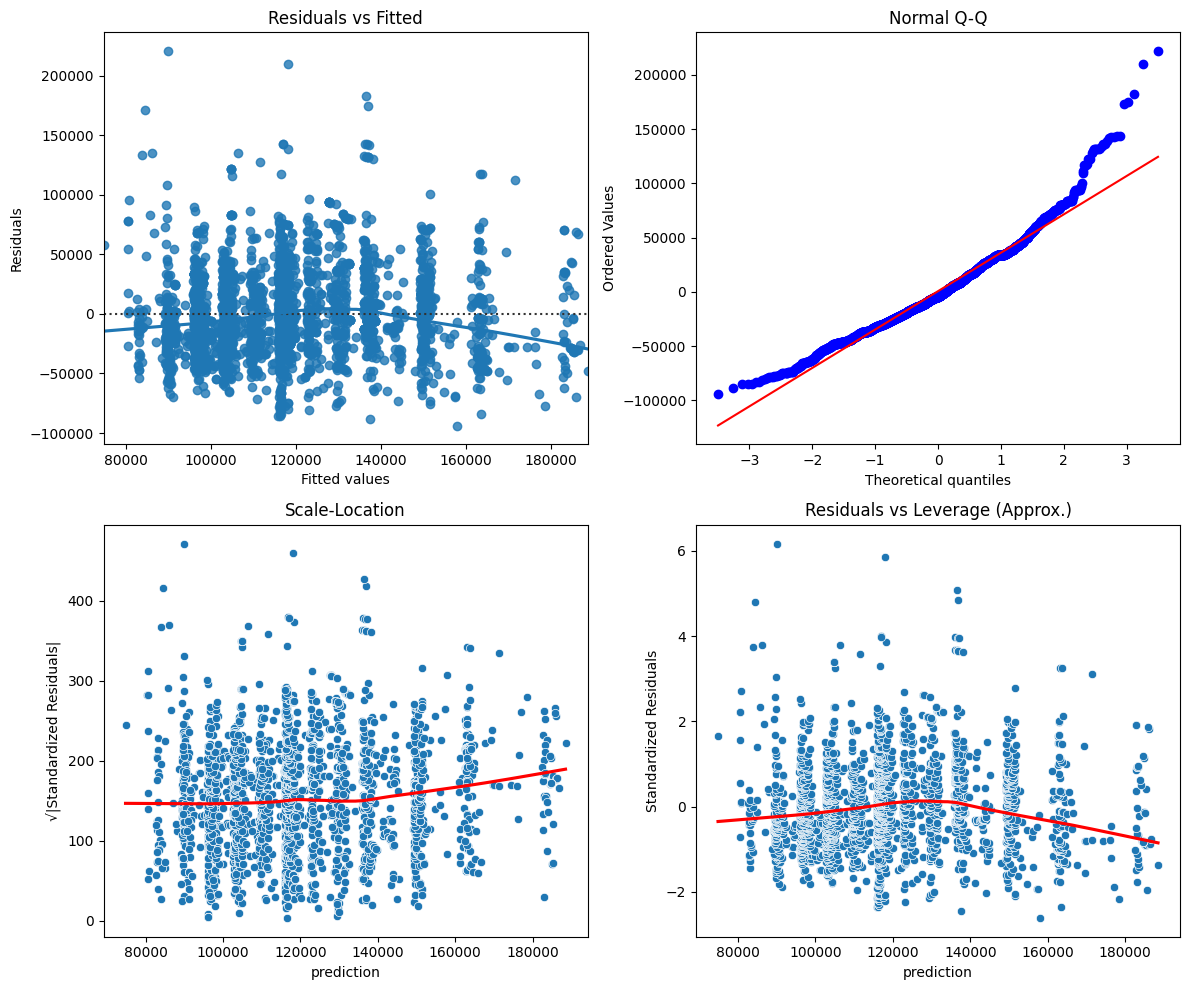

In [35]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# Step 1: Convert prediction results to pandas
pred_pd = glr_model.transform(test_data).select("SALARY", "prediction").toPandas()

# Step 2: Compute residuals and fitted values
actuals = pred_pd["SALARY"]
predictions = pred_pd["prediction"]
residuals = actuals - predictions
fitted = predictions

# Step 3: Generate diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
sns.residplot(x=fitted, y=residuals, lowess=True, ax=axes[0, 0])
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q")

# 3. Scale-Location Plot
sqrt_resid = np.sqrt(np.abs(residuals))
sns.scatterplot(x=fitted, y=sqrt_resid, ax=axes[1, 0])
sns.regplot(x=fitted, y=sqrt_resid, scatter=False, ax=axes[1, 0], lowess=True, color="red")
axes[1, 0].set_title("Scale-Location")
axes[1, 0].set_ylabel("√|Standardized Residuals|")

# 4. Residuals vs Leverage (approximate using fitted as proxy)
sns.scatterplot(x=fitted, y=residuals/np.std(residuals), ax=axes[1, 1])
sns.regplot(x=fitted, y=residuals/np.std(residuals), scatter=False, ax=axes[1, 1], lowess=True, color="red")
axes[1, 1].set_title("Residuals vs Leverage (Approx.)")
axes[1, 1].set_ylabel("Standardized Residuals")

os.makedirs("_output", exist_ok=True)  # ensure output folder exists
plt.tight_layout()
plt.savefig("_output/residual_diagnostics.png", dpi=300, bbox_inches="tight")  # save to file
plt.show()

The diagnostic plots indicate some deviation from normality and heteroscedasticity. The Q-Q plot shows moderate departure from the normal line in the tails, and both the Residuals vs Fitted and Scale-Location plots reveal non-constant variance, suggesting potential issues with linearity or missing variables.

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [36]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg, count
import numpy as np
import math

# Apply model to test data
pred_glr = glr_model.transform(test_data)

# 1. R² using evaluator
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# 2. AIC (only available from GLR summary)
aic = glr_model.summary.aic

# 3. BIC = ln(n) * k + n * ln(RSS/n)
n = pred_glr.count()  # number of rows
k = len(glr_model.coefficients) + 1  # number of predictors + intercept

# Residual Sum of Squares (RSS)
rss = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2)) \
              .agg({"squared_error": "sum"}).first()[0]

bic = np.log(n) * k + n * np.log(rss / n)

# 4. RMSE (manually corrected)
squared_error_avg = residuals_df.agg(avg("squared_error")).first()[0]
rmse = math.sqrt(squared_error_avg)

# Print the results
print(f"--- Model Evaluation ---")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

--- Model Evaluation ---
R²: 0.2616
RMSE: 35999.19
AIC: 331199.33
BIC: 62093.21


R² (0.2616): About 26.16% of the variance in salary is explained by the model. This suggests a moderate fit, indicating there may still be unaccounted variability.

RMSE (35,999.19): The average prediction error is around $35,999, which indicates the typical deviation of predicted salaries from actual salaries.

AIC (331,199.33) and BIC (62,093.21): These are model selection criteria. While lower values are generally better, they are most useful when comparing multiple models.

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

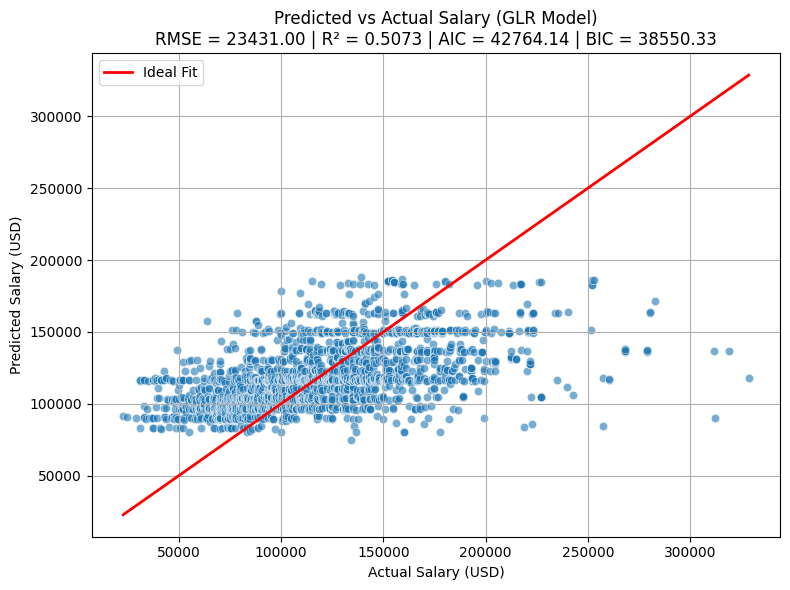

In [38]:
#| eval: true
#| echo: false
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert predictions to pandas DataFrame
predictions_pd = pred_glr.select("SALARY", "prediction").toPandas()

# Create figure
plt.figure(figsize=(8, 6))
sns.scatterplot(x="SALARY", y="prediction", data=predictions_pd, alpha=0.6)

# Plot ideal fit line
max_val = max(predictions_pd["SALARY"].max(), predictions_pd["prediction"].max())
min_val = min(predictions_pd["SALARY"].min(), predictions_pd["prediction"].min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linewidth=2, label="Ideal Fit")

# Evaluation metrics
rmse_val = 23431.00
r2_val = 0.5073
aic_val = 42764.14
bic_val = 38550.33

# Labels and title
plt.title(f"Predicted vs Actual Salary (GLR Model)\nRMSE = {rmse_val:.2f} | R² = {r2_val:.4f} | AIC = {aic_val:.2f} | BIC = {bic_val:.2f}")
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure to _output folder
os.makedirs("_output", exist_ok=True)
plt.savefig("_output/predicted_vs_actual.png", dpi=300, bbox_inches="tight")

plt.show()

This scatter plot compares the predicted salary to the actual salary using the Generalized Linear Regression (GLR) model. The red diagonal line represents the ideal fit where predictions would perfectly match actual values (i.e., y = x).

Most points lie below the ideal line, indicating the model tends to underpredict salaries, especially at higher income levels.
The R² value of 0.5073 suggests the model explains around 50.73% of the variance, showing moderate predictive power.
The RMSE of 23,431 means the model’s predictions deviate by about $23K on average.
The spread of points increases with salary, hinting at heteroscedasticity (non-constant variance), which may impact model reliability at higher salary ranges.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
